In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sys.path.append(os.path.abspath(".."))

In [3]:
from src.data_loader import DataLoader
from src.utils import pd  # GPU (cuDF) or CPU (Pandas)

🐢 Compatibility Mode: CPU (Pandas) for ETL -> GPU for Training


In [5]:
# Configure graphics settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [6]:
# Load Data (1M rows is sufficient and efficient for initial analysis)
print("📥 Loading Data...")
loader = DataLoader(data_path="../data/raw")

# Merge train data with building and weather metadata
# (Manually simulating our custom function for a quick run)
train = pd.read_csv("../data/raw/train.csv", nrows=1_000_000)
building = pd.read_csv("../data/raw/building_metadata.csv")
weather = pd.read_csv("../data/raw/weather_train.csv")

📥 Loading Data...


In [7]:
# Merge operations (for analysis purposes)
train = train.merge(building, on="building_id", how="left")

# Converting timestamps is mandatory for merging weather data
train["timestamp"] = pd.to_datetime(train["timestamp"])
weather["timestamp"] = pd.to_datetime(weather["timestamp"])
df = train.merge(weather, on=["site_id", "timestamp"], how="left")

print(f"✅ Analysis Dataset Ready: {df.shape}")

✅ Analysis Dataset Ready: (1000000, 16)


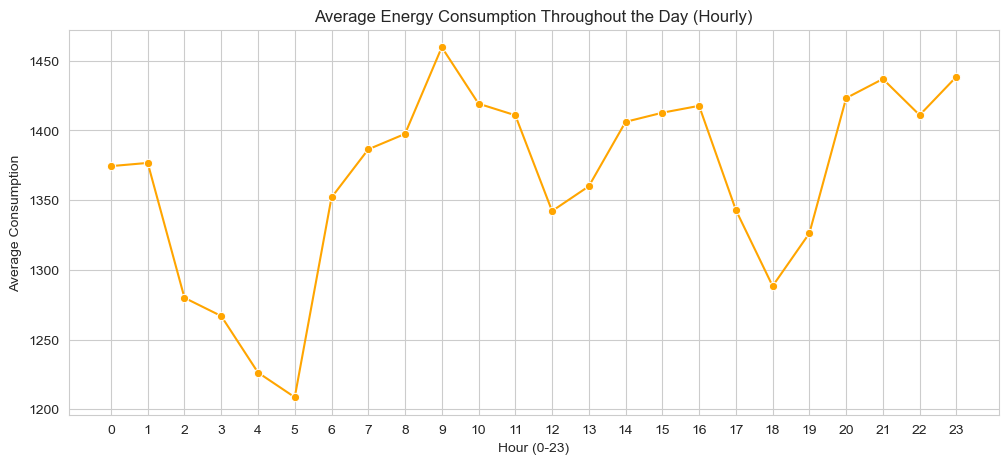

In [8]:
# Visualization libraries (Matplotlib/Seaborn) execute on the CPU.
# Therefore, we may need to convert the data to Pandas (if using cuDF/GPU).
if hasattr(df, "to_pandas"):
    pdf = df.to_pandas()
else:
    pdf = df

# 1. Average Hourly Consumption (Daily Seasonality)
plt.figure(figsize=(12, 5))
hourly_avg = pdf.groupby(pdf["timestamp"].dt.hour)["meter_reading"].mean()
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker="o", color="orange")
plt.title("Average Energy Consumption Throughout the Day (Hourly)")
plt.xlabel("Hour (0-23)")
plt.ylabel("Average Consumption")
plt.xticks(range(0, 24))
plt.show()

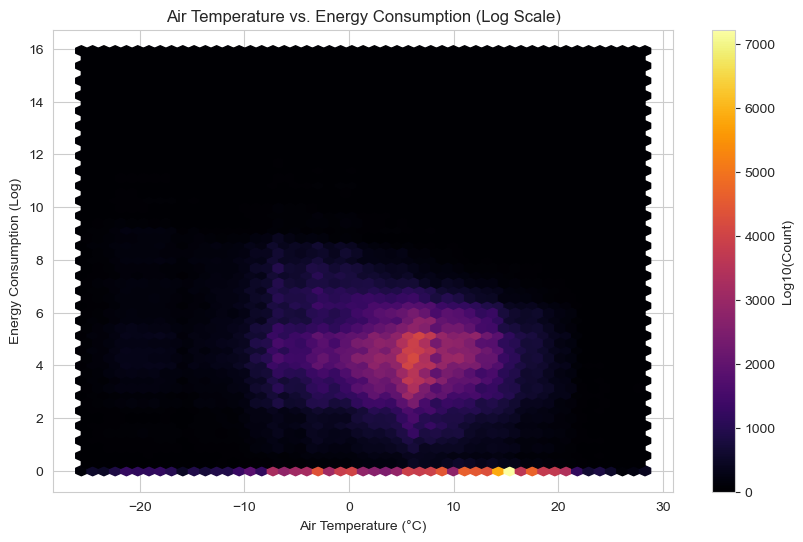

In [9]:
# Temperature vs. Consumption (Hexbin is more efficient than Scatter Plot for large data)
plt.figure(figsize=(10, 6))
plt.hexbin(
    pdf["air_temperature"], np.log1p(pdf["meter_reading"]), gridsize=50, cmap="inferno"
)
plt.colorbar(label="Log10(Count)")  # or simply "Count"
plt.title("Air Temperature vs. Energy Consumption (Log Scale)")
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Energy Consumption (Log)")
plt.show()

/tmp/ipykernel_10782/509722853.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


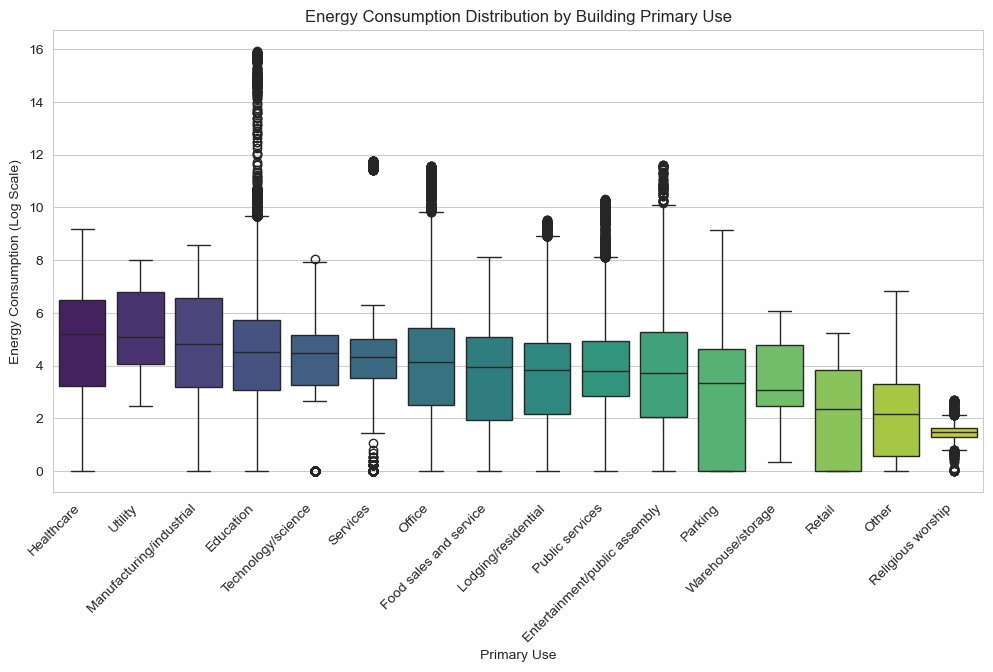

In [10]:
plt.figure(figsize=(12, 6))

# Sort categories by median consumption for better visualization
order = (
    pdf.groupby("primary_use")["meter_reading"]
    .median()
    .sort_values(ascending=False)
    .index
)

sns.boxplot(
    x="primary_use",
    y=np.log1p(pdf["meter_reading"]),
    data=pdf,
    order=order,
    palette="viridis",
)

# Rotate labels for better readability
plt.xticks(rotation=45, ha="right")
plt.title("Energy Consumption Distribution by Building Primary Use")
plt.ylabel("Energy Consumption (Log Scale)")
plt.xlabel("Primary Use")
plt.show()

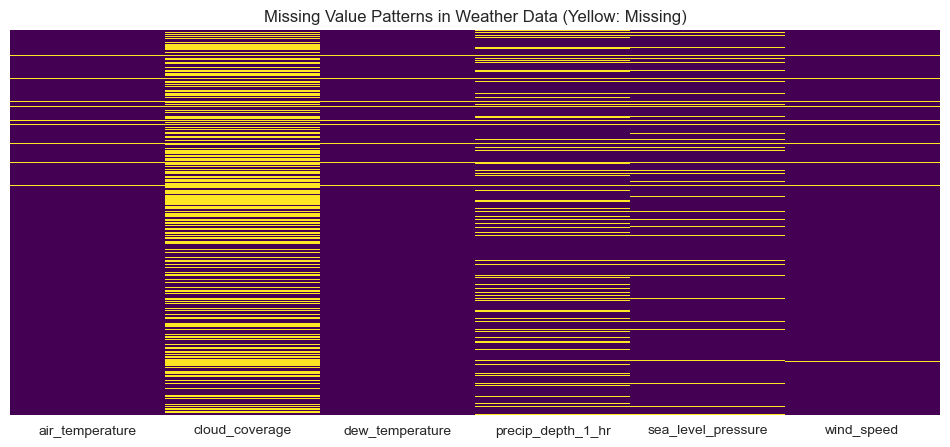

In [11]:
plt.figure(figsize=(12, 5))

# Analyze the distribution of missing values across weather features
weather_cols = [
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "sea_level_pressure",
    "wind_speed",
]

# Visualize missing values (Sparsity Matrix)
sns.heatmap(pdf[weather_cols].isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Value Patterns in Weather Data (Yellow: Missing)")
plt.show()